In [342]:
import requests
from datetime import datetime, timedelta, UTC
import pandas as pd
from io import BytesIO
import json
from collections import defaultdict

session = requests.Session()
url = "http://ionbeam-ichange.ecmwf-ichange.f.ewcloud.host/api/v1/"
url = "http://localhost:5002/api/v1/"

def api_get(path, *args, **kwargs):
    r = session.get(url + path, stream=True, *args, **kwargs)
    if not r.ok:
        print(f"API Error")
        print(json.dumps(r.json(), indent = 4))
    return r

In [343]:
def sort_by_platform(stations) -> dict[str, list[dict]]:
    by_platform = defaultdict(list)
    for s in stations:
        by_platform[s["platform"]].append(s)
    return by_platform
    
lookback = timedelta(hours = 5) 

all_stations = api_get("stations", params = {
}).json()

recent_stations = api_get("stations", params = {
    "start_time" : datetime.now(UTC) - lookback
}).json()

print("All stations")
all_by_platform = sort_by_platform(all_stations)
print({k : len(v) for k, v in all_by_platform.items()})
print()


print(f"Recent ({lookback})")
print({k : len(v) for k, v in sort_by_platform(recent_stations).items()})
print()

All stations
{'smart_citizen_kit': 5, 'meteotracker': 2119, 'acronet': 99}

Recent (5:00:00)
{'meteotracker': 31, 'acronet': 99, 'smart_citizen_kit': 4}



## Total Meteotracker datasets

In [344]:
dates = [datetime.fromisoformat(s['time_span']["end"]) for s in all_by_platform['meteotracker']]
earliest, latest = min(dates), max(dates)
print(f"Meteotracker: {len(all_by_platform['meteotracker'])} tracks.")
print(f"Earliest ingested data: {earliest}")
print(f"Most recent ingested data: {latest}")

Meteotracker: 2119 tracks.
Earliest ingested data: 2024-12-20 15:38:36.173000+00:00
Most recent ingested data: 2025-01-19 15:14:46.716000+00:00


## Total Acronet datasets

In [345]:
def get_all_granules_by_platform(platform):
    granules = api_get("list", params = {'platform': platform}).json()
    dates = [datetime.fromisoformat(d["datetime"]) for d in granules]
    # print(set(g["mars_request"]["platform"] for g in granules))
    assert all(g["mars_request"]["platform"] == platform for g in granules)
    return granules, dates

acronet_granules, dates = get_all_granules_by_platform(platform = "acronet")
earliest, latest = min(dates), max(dates)

print(f"Acronet: {len(all_by_platform['acronet'])} distinct stations.")
print(f"Earliest ingested data: {earliest.date()} Most recent ingested data: {latest.date()}")
print(f"Ingested data: {len(acronet_granules)} acronet data granules.")

Acronet: 99 distinct stations.
Earliest ingested data: 2025-01-11 Most recent ingested data: 2025-01-19
Ingested data: 193 acronet data granules.


## Total Smart Citizen Kit Datasets

In [346]:
sck_granules, dates = get_all_granules_by_platform(platform = "smart_citizen_kit")
earliest, latest = min(dates), max(dates)

print(f"Smart Citizen Kit: {len(all_by_platform['smart_citizen_kit'])} distinct stations.")
print(f"Earliest ingested data: {earliest} Most recent ingested data: {latest}")
print(f"Ingested data: {len(sck_granules)} data granules.")

Smart Citizen Kit: 5 distinct stations.
Earliest ingested data: 2025-01-12 15:00:00+00:00 Most recent ingested data: 2025-01-19 15:00:00+00:00
Ingested data: 169 data granules.


## Retrieving chunked data for continuous data streams
Acronet, Smart Citizen Kit

In [347]:
example_station = all_by_platform["acronet"][-1]
print(example_station)
args = {
    "start_time" : (latest - timedelta(hours = 5)).isoformat(),
    "end_time": latest.isoformat(),
}
data = api_get("retrieve", params = example_station["mars_selection"] | args | dict(format = "csv"))
df = pd.read_csv(BytesIO(data.content))
df

{'name': 'Fontanigorda - Pluvio', 'description': None, 'platform': 'acronet', 'external_id': 'fontanigorda___pluvio', 'internal_id': '579617bdd8ea475e', 'aggegation_type': 'by_time', 'location': {'lat': 44.546543, 'lon': 9.304368}, 'time_span': {'start': '2025-01-11T15:16:00+00:00', 'end': '2025-01-19T15:06:00+00:00'}, 'authors': [{'id': 4, 'name': 'acronet'}], 'mars_selection': {'class': 'rd', 'expver': 'xxxx', 'stream': 'lwda', 'aggregation_type': 'by_time', 'platform': 'acronet', 'station_id': '579617bdd8ea475e', 'date': '20250111/to/20250119/by/1'}}


Unnamed: 0 platform   author        station_id    external_station_id  \
0            42  acronet  acronet  579617bdd8ea475e  fontanigorda___pluvio   
1           130  acronet  acronet  579617bdd8ea475e  fontanigorda___pluvio   
2           208  acronet  acronet  579617bdd8ea475e  fontanigorda___pluvio   
3           389  acronet  acronet  579617bdd8ea475e  fontanigorda___pluvio   
4           443  acronet  acronet  579617bdd8ea475e  fontanigorda___pluvio   
..          ...      ...      ...               ...                    ...   
307         240  acronet  acronet  579617bdd8ea475e  fontanigorda___pluvio   
308         392  acronet  acronet  579617bdd8ea475e  fontanigorda___pluvio   
309         457  acronet  acronet  579617bdd8ea475e  fontanigorda___pluvio   
310         577  acronet  acronet  579617bdd8ea475e  fontanigorda___pluvio   
311         597  acronet  acronet  579617bdd8ea475e  fontanigorda___pluvio   

              station_name aggregation_type  chunk_date  chunk_time  \
0    Fontanigorda - Pluvio          by_time    20250119        1000   
1    Fontanigorda - Pluvio          by_time    20250119        1000   
2    Fontanigorda - Pluvio          by_time    20250119        1000   
3    Fontanigorda - Pluvio          by_time    20250119        1000   
4    Fontanigorda - Pluvio          by_time    20250119        1000   
..                     ...              ...         ...         ...   
307  Fontanigorda - Pluvio          by_time    20250119        1500   
308  Fontanigorda - Pluvio          by_time    20250119        1500   
309  Fontanigorda - Pluvio          by_time    20250119        1500   
310  Fontanigorda - Pluvio          by_time    20250119        1500   
311  Fontanigorda - Pluvio          by_time    20250119        1500   

           lat  ...  wind_direction_near_surface  \
0    44.546543  ...                    131.20000   
1    44.546543  ...                    144.40001   
2    44.546543  ...                    185.60000   
3    44.546543  ...                    162.80000   
4    44.546543  ...                    120.50000   
..         ...  ...                          ...   
307  44.546543  ...                    162.10000   
308  44.546543  ...                    235.30000   
309  44.546543  ...                    262.10000   
310  44.546543  ...                    229.50000   
311  44.546543  ...                    262.90000   

     air_temperature_near_surface  internal_temperature  wind_gust_direction  \
0                             3.2                   6.6                  NaN   
1                             3.3                   6.9                  NaN   
2                             3.4                   6.8                  NaN   
3                             3.3                   6.9                  NaN   
4                             3.3                   7.0                  NaN   
..                            ...                   ...                  ...   
307                           3.2                   6.3                  NaN   
308                           3.2                   6.3                  NaN   
309                           3.3                   6.3                  NaN   
310                           3.3                   6.2                  NaN   
311                           3.2                   6.1                  NaN   

     signal_strength  wind_gust  battery_level  wind_speed_near_surface  \
0                NaN        0.8      13.960000                      0.4   
1                NaN        0.7      13.230000                      0.2   
2                NaN        0.8      13.240000                      0.2   
3                NaN        1.4      13.250000                      0.5   
4               31.0        0.8      13.230000                      0.7   
..               ...        ...            ...                      ...   
307              NaN        0.9      12.809999                      0.3   
308             31.0        0

{'name': 'Fontanigorda - Pluvio', 'description': None, 'platform': 'acronet', 'external_id': 'fontanigorda___pluvio', 'internal_id': '579617bdd8ea475e', 'aggegation_type': 'by_time', 'location': {'lat': 44.546543, 'lon': 9.304368}, 'time_span': {'start': '2025-01-11T15:16:00+00:00', 'end': '2025-01-19T15:06:00+00:00'}, 'authors': [{'id': 4, 'name': 'acronet'}], 'mars_selection': {'class': 'rd', 'expver': 'xxxx', 'stream': 'lwda', 'aggregation_type': 'by_time', 'platform': 'acronet', 'station_id': '579617bdd8ea475e', 'date': '20250111/to/20250119/by/1'}}
Latest data: 2025-01-19 15:06:00+00:00


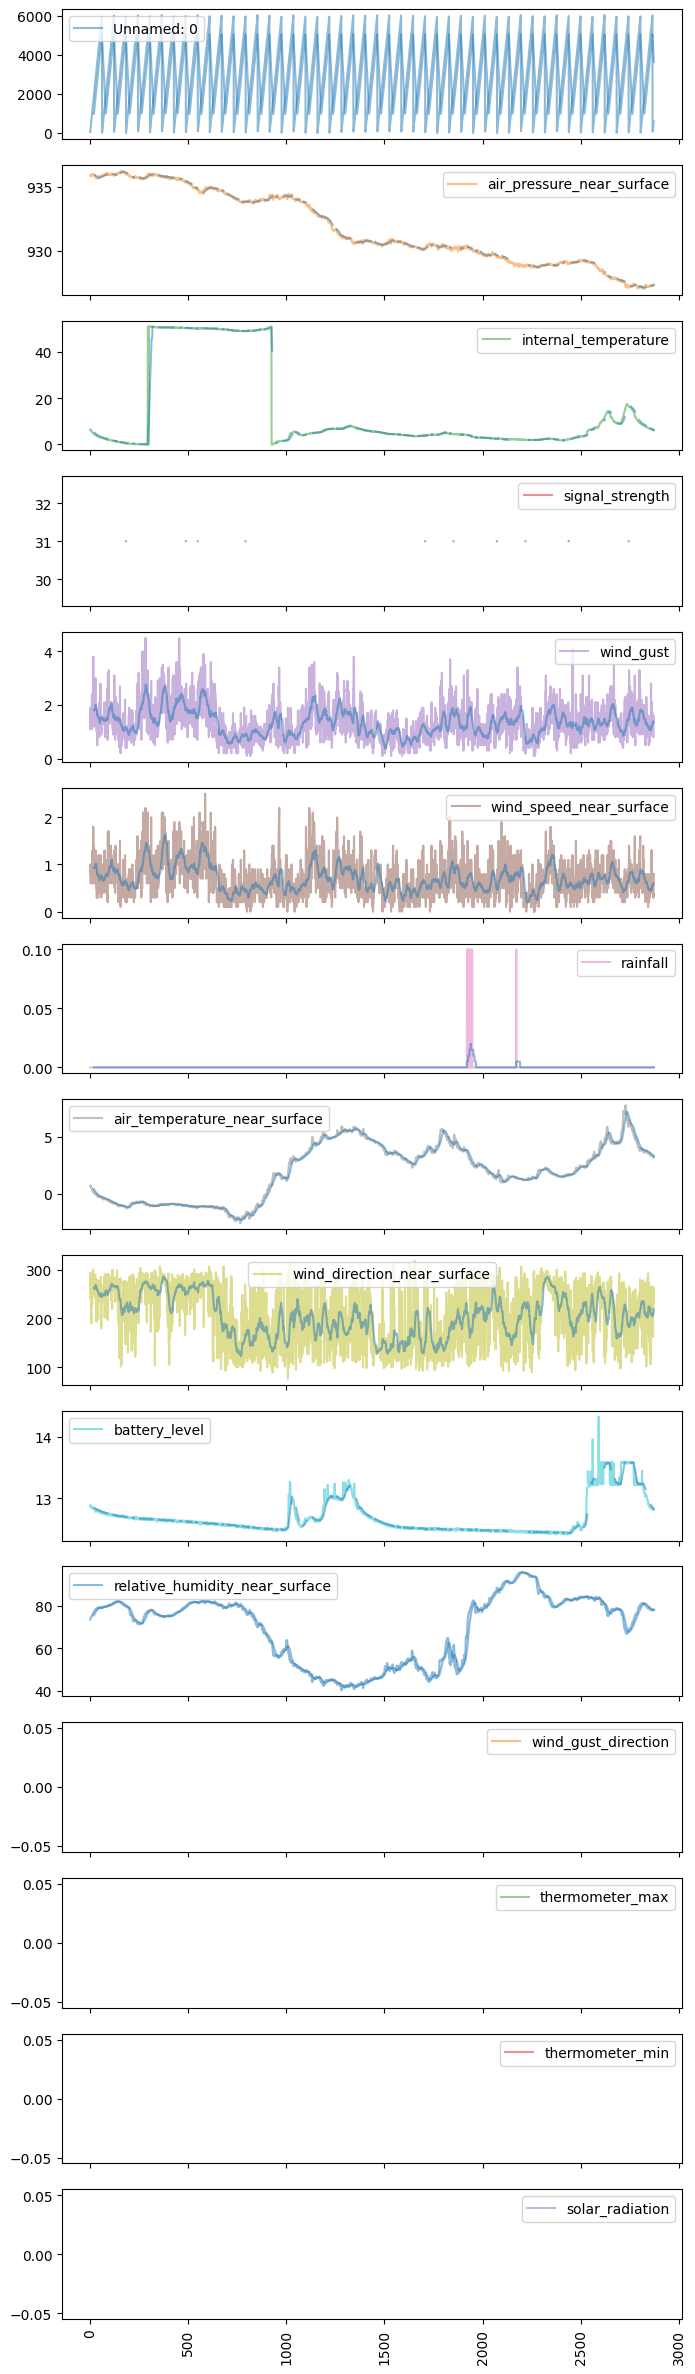

In [348]:
def plot_example_station(example_station):
    latest = datetime.fromisoformat(example_station["time_span"]["end"])
    print(f"Latest data: {latest}")
    args = {
        "start_time" : (latest - timedelta(hours = 48)).isoformat(),
        "end_time": latest.isoformat(),
    }
    
    data = api_get("retrieve", params = example_station["mars_selection"] | args | dict(format = "csv"))
    df = pd.read_csv(BytesIO(data.content))
    
    exclude_columns = {"external_id", "date", "lat", "lon", "altitude", "chunk_date", "chunk_time"}
    numeric_columns = [col for col, dtype in zip(df.columns, df.dtypes) 
                       if (dtype == "float64" or dtype == "int64")
                       and col not in exclude_columns]
    
    axes = df.plot(
        y = numeric_columns,
        subplots=True, 
        layout=(len(numeric_columns), 1), figsize=(8, 2*len(numeric_columns)), 
        sharex=True, rot=90,
    alpha = 0.5)

    for col, ax in zip(numeric_columns, axes.flatten()):
        ax.plot(df.index, df[col].rolling(window=20).mean(), label = "rolling mean", alpha = 0.5)
    

example_station = all_by_platform["acronet"][-1]
print(example_station)
plot_example_station(example_station)

{'name': 'I-CHANGE CIMA ARENZANO', 'description': None, 'platform': 'smart_citizen_kit', 'external_id': '16517', 'internal_id': 'b93bfbb97112ae04', 'aggegation_type': 'by_time', 'location': {'lat': 44.3993, 'lon': 8.67264}, 'time_span': {'start': '2025-01-13T16:00:58+00:00', 'end': '2025-01-19T15:05:59+00:00'}, 'authors': [{'id': 5, 'name': 'smart_citizen_kit'}], 'mars_selection': {'class': 'rd', 'expver': 'xxxx', 'stream': 'lwda', 'aggregation_type': 'by_time', 'platform': 'smart_citizen_kit', 'station_id': 'b93bfbb97112ae04', 'date': '20250113/to/20250119/by/1'}}
Latest data: 2025-01-19 15:05:59+00:00


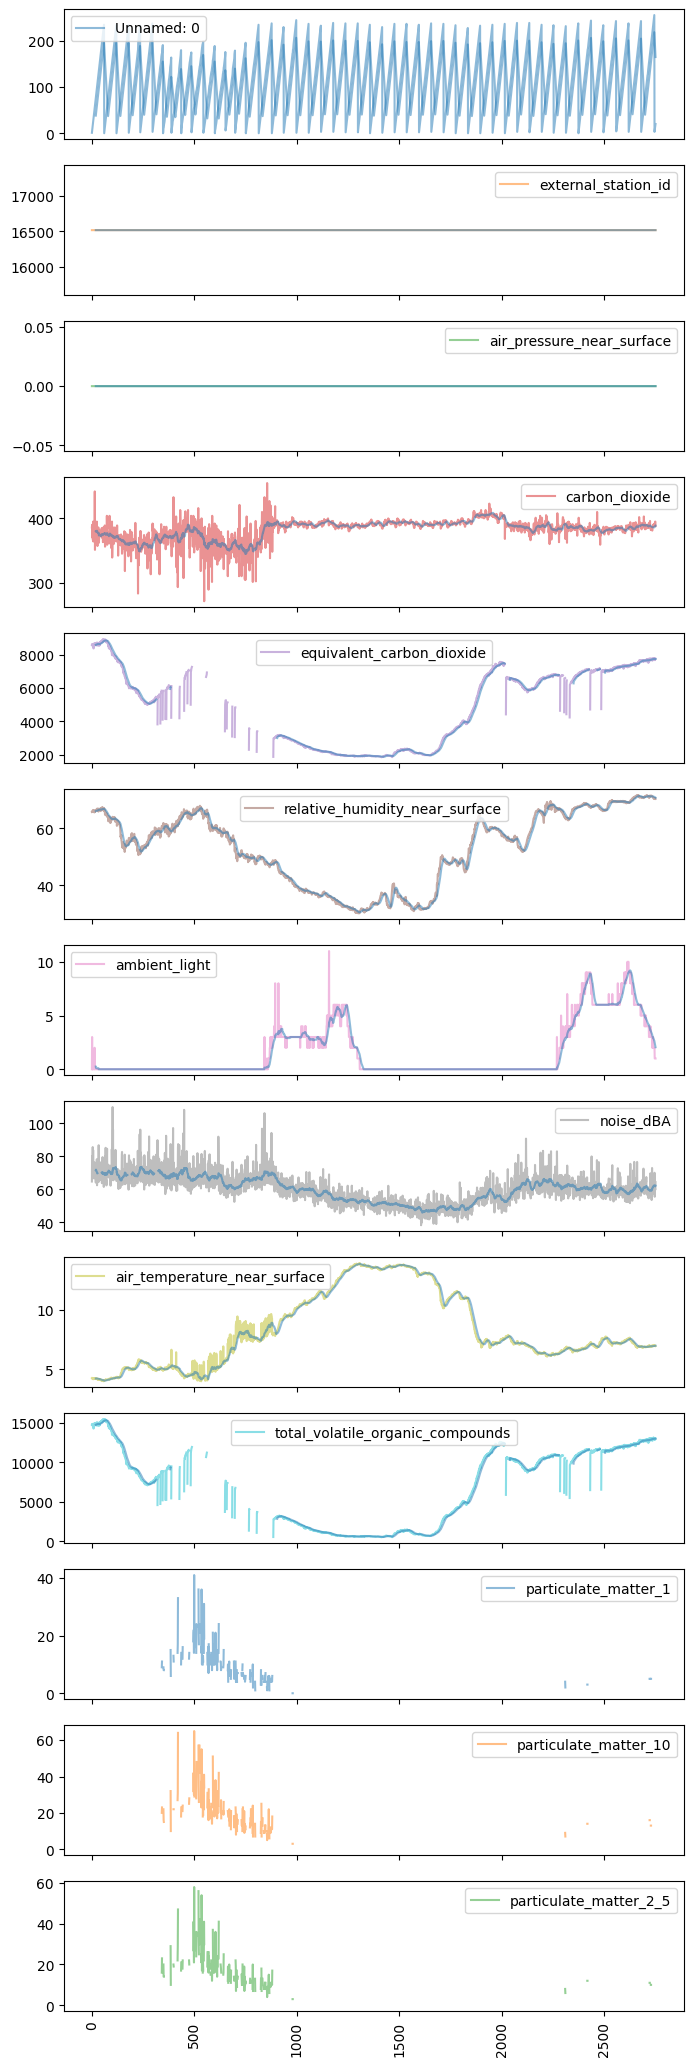

In [349]:
example_station = all_by_platform["smart_citizen_kit"][-1]
print(example_station)
plot_example_station(example_station)

## Retrieve and plot a Meteotracker track

In [350]:
example_station = all_by_platform["meteotracker"][-1]
print("track time span", example_station["time_span"])

print(json.dumps(example_station["mars_selection"], indent = 4))
granule_list = api_get("list", params = example_station["mars_selection"]).json()

print(f"The above MARS request matches {len(granule_list)} data granule(s).")

args = {
    "format" : "parquet"
}

track time span {'start': '2025-01-12T11:53:55.198000+00:00', 'end': '2025-01-12T14:54:14.232000+00:00'}
{
    "class": "rd",
    "expver": "xxxx",
    "stream": "lwda",
    "aggregation_type": "by_time",
    "platform": "meteotracker",
    "station_id": "060ebfb891f8e7e3",
    "date": "20250112",
    "time": "1100/to/1400/by/1"
}
The above MARS request matches 19 data granule(s).


In [356]:
df.index

Index([4359, 4365, 4371, 4379, 4381, 4384, 4391, 4400, 4402, 4408,
       ...
       4982, 4987, 4994, 5000, 5003, 5008, 5015, 5019, 5020, 5027],
      dtype='int64', length=3216)

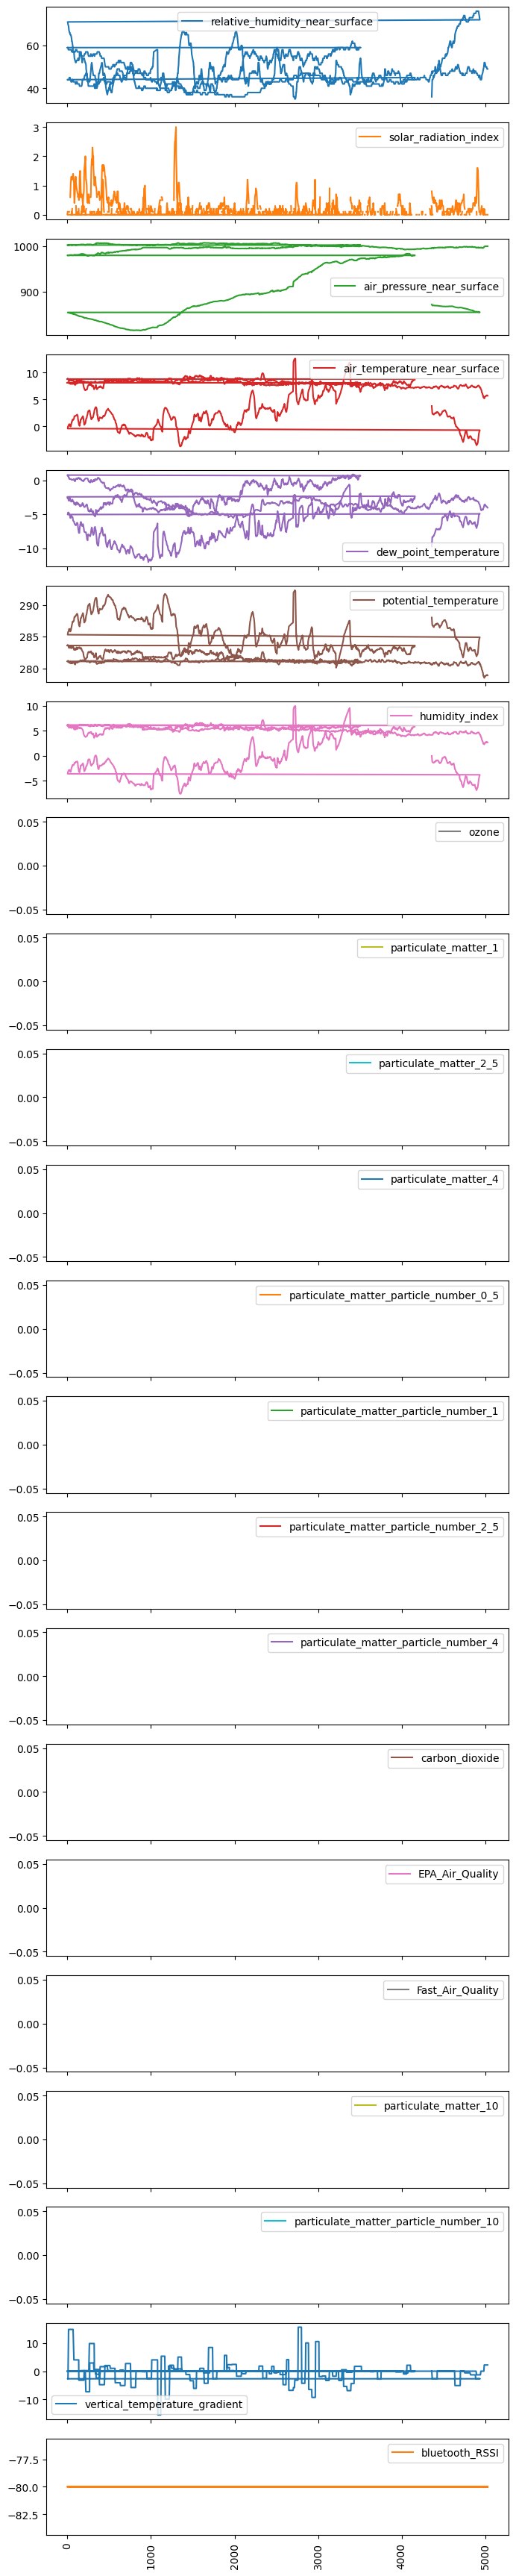

In [355]:
data = api_get("retrieve", params = example_station["mars_selection"] | args)
df = pd.read_parquet(BytesIO(data.content))

exclude_columns = {"external_id", "date", "lat", "lon", "altitude"}
numeric_columns = [col for col, dtype in zip(df.columns, df.dtypes) 
                   if (dtype == "float64" or dtype == "int64")
                   and col not in exclude_columns]

axes = df.plot(
    y = numeric_columns,
    subplots=True, layout=(len(numeric_columns), 1), figsize=(8, 2*len(numeric_columns)), sharex=True, rot=90)


In [352]:
import geopandas as gpd
geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs=4326)
geo_df.explore(column = "altitude")

## Retrieve ALL data for ALL platforms in the last few hours:

In [353]:
data = api_get("retrieve", params = dict(
    # platform = "acronet",
    start_time = datetime.now(UTC) - timedelta(hours = 3),
    end_time = datetime.now(UTC),
    format = "parquet"
))
df = pd.read_parquet(BytesIO(data.content))

In [354]:
import geopandas as gpd

# Just show one point from each station and track
deduped = df.drop_duplicates(subset=["station_id"])
gdf = gpd.GeoDataFrame(
    deduped,
    geometry=gpd.points_from_xy(deduped['lon'], deduped['lat']),
    crs="EPSG:4326"
)
gdf.explore()